In [1]:
import sys, os, h5py
import numpy as np

try:
    from tqdm.auto import trange
except Exception as e:
    trange = range

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm

import agama 
agama.setUnits(mass=1, length=1, velocity=1) # Msol, kpc, km/s. Time is in kpc/(kms/s)

from importlib import reload
from helper_funcs import * # this is just a collection of helper functions from the main repo.
from agama_BFEs import *

plt.style.use('dark_background')
%matplotlib inline

In [2]:
# # define Simulation paths and files
# # Load an example Snapshot following Nico's example
SIM_DIR = os.path.join('data/', 'Model_108')
SNAP_NAME = 'snapshot'
SIM_ID = 108
SUITE_NAME = 'Sheng24'
CENTER_FILE = f'MW_LMC_orbits_iso.txt'

# # load the MW-LMC centers for this Shen24 suite
times, rmw, vmw, rlmc, vlmc = load_sheng24_exp_center(SIM_DIR, CENTER_FILE, SIM_ID, return_vel=True)

# # to match with Nico's dictionary structure
sim_params = dict()
sim_params['time'] = times
sim_params['mw_center'] = rmw
sim_params['mw_vel'] = vmw
sim_params['lmc_center'] = rlmc
sim_params['lmc_vel'] = vlmc

LMC_pos_in_MWframe = sim_params['lmc_center'] - sim_params['mw_center']
LMC_vel_in_MWframe = sim_params['lmc_vel'] - sim_params['mw_vel']

Gyr_to_AgamaTime = 1.0227 # 1 Gyr in Agama time units (kpc/(km/s))
time_in_Agama = sim_params['time'] * Gyr_to_AgamaTime # the conversion to get the orbits to matchup

LMC_traj = np.column_stack([time_in_Agama, LMC_pos_in_MWframe, LMC_vel_in_MWframe])

# read a snapshot + fit exp

In [3]:
# # Load a specific snapshot: 
nsnap = 100 # # example snapshot
print(f'Snapshot: {nsnap:03d}, T={times[nsnap]:.2f} Gyr')
components = ['MWhalo', 'LMChalo', 'MWdisk', 'MWbulge']
part = load_particle_data(SIM_DIR, SNAP_NAME, components, nsnap, SUITE_NAME, msun_units=True)

[INFO] Header 'Time': 2.0
[INFO] Header 'Redshift': 0.0
[INFO] Header 'BoxSize': 0.0
[INFO] Header 'NumPart_Total': [     0 849690  68000   5000      0      0]
[INFO] Header 'MassTable': [0. 0. 0. 0. 0. 0.]


Snapshot: 100, T=2.00 Gyr


[INFO] Header 'Time': 2.0
[INFO] Header 'Redshift': 0.0
[INFO] Header 'BoxSize': 0.0
[INFO] Header 'NumPart_Total': [     0 849690  68000   5000      0      0]
[INFO] Header 'MassTable': [0. 0. 0. 0. 0. 0.]
[INFO] Header 'Time': 2.0
[INFO] Header 'Redshift': 0.0
[INFO] Header 'BoxSize': 0.0
[INFO] Header 'NumPart_Total': [     0 849690  68000   5000      0      0]
[INFO] Header 'MassTable': [0. 0. 0. 0. 0. 0.]
[INFO] Header 'Time': 2.0
[INFO] Header 'Redshift': 0.0
[INFO] Header 'BoxSize': 0.0
[INFO] Header 'NumPart_Total': [     0 849690  68000   5000      0      0]
[INFO] Header 'MassTable': [0. 0. 0. 0. 0. 0.]


# Generate all models

In [4]:
# # # generate all models at all steps:
# # # Load a specific snapshot: 
# lmax, mmax= 8, 8
# from tqdm import trange

# components = ['MWhalo', 'LMChalo', 'MWdisk', 'MWbulge']
# for nsnap in trange(0, 101): # # example snapshot
#     # print(f'Snapshot: {nsnap:03d}, T={times[nsnap]:.2f} Gyr')
#     part = load_particle_data(SIM_DIR, SNAP_NAME, components, nsnap, SUITE_NAME, msun_units=True)
#     fitAgamaBFE(
#         part, 
#         sim_params, 
#         nsnap,
#         lmax=lmax, 
#         mmax=mmax,
#         verbose=False,
# )

# Test out the potentials for Sanity

In [3]:
pot_MWhalo_000 = agama.Potential(file='potential/000.MW.none_8.coef_mult')
pot_MWdisk_000 = agama.Potential(file='potential/000.MW.none_8.coef_cylsp')
pot_LMChalo_000 = agama.Potential(file='potential/000.LMC.none_8.coef_mult', center=LMC_traj[0, 1:4])
potTotal_000 = agama.Potential(pot_MWhalo_000, pot_MWdisk_000, pot_LMChalo_000)

pot_MWhalo_100 = agama.Potential(file='potential/100.MW.none_8.coef_mult')
pot_MWdisk_100 = agama.Potential(file='potential/100.MW.none_8.coef_cylsp')
pot_LMChalo_100 = agama.Potential(file='potential/100.LMC.none_8.coef_mult', center=LMC_traj[100, 1:4])
potTotal_100 = agama.Potential(pot_MWhalo_100, pot_MWdisk_100, pot_LMChalo_100)

In [4]:
pot_MWhalo_evolv = agama.Potential(file=f'data/MW.none_8.coef_mult.ini')
pot_MWdisk_evolv = agama.Potential(file=f'data/MW.none_8.coef_cylsp.ini')
pot_LMChalo_evolv = agama.Potential(file=f'data/LMC.none_8.coef_mult.ini', center=LMC_traj[0::100, :4])
potTotal_evolv = agama.Potential(pot_MWhalo_evolv, pot_MWdisk_evolv, pot_LMChalo_evolv) # ignore acceleration for now.

In [5]:
potTotal_000.force([10, 0, 0]), potTotal_100.force([10, 0, 0])

(array([-4437.46931968,    12.85397971,   -83.81285728]),
 array([-4525.86567917,  -115.14171795,  -208.94165195]))

In [6]:
potTotal_evolv.force([10, 0, 0], t=0), potTotal_evolv.force([10, 0, 0], t=2)

(array([-4437.46931968,    12.85397971,   -83.81285728]),
 array([-4544.00602828,  -141.46895813,  -236.72358861]))

/tmp/ipykernel_5607/1266092731.py:20: RuntimeWarning: invalid value encountered in log10
  im = ax[i].contourf(grid, grid, np.log10(den), levels=15, cmap='cubehelix')


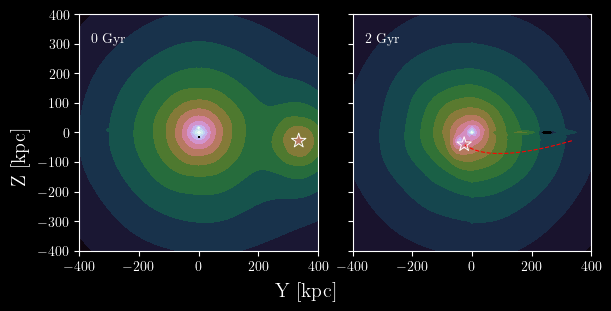

In [7]:
grid = np.linspace(-400, 400, 101)
xyz = np.column_stack(
    [np.zeros(len(grid)**2),
     np.repeat(grid, len(grid)),
     np.tile(grid, len(grid)),
    ]
)
den_000 = potTotal_000.density(xyz).reshape(len(grid), len(grid)).T
den_100 = potTotal_100.density(xyz).reshape(len(grid), len(grid)).T

fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True, constrained_layout=True)

# Plotting loops/logic to keep code DRY (Don't Repeat Yourself)
times = [0, 2]
densities = [den_000, den_100]
labels = ["0 Gyr", "2 Gyr"]

for i, (t_val, den, lbl) in enumerate(zip(times, densities, labels)):
    # Contour plot
    im = ax[i].contourf(grid, grid, np.log10(den), levels=15, cmap='cubehelix')
    
    # Filter trajectory for the specific time
    mask = LMC_traj[:, 0] <= t_val
    path = LMC_traj[mask]
    
    if len(path) > 0:
        # 1. Red dashed line
        ax[i].plot(path[:, 2], path[:, 3], '--', c='r', lw=0.8)
        
        # 2. Unfilled star at the FINAL location
        # facecolors='none' makes it unfilled
        ax[i].scatter(path[-1, 2], path[-1, 3], marker='*', s=120, 
                      facecolors='none', edgecolors='white', linewidths=0.7, zorder=5)

    # 3. Annotations on top left
    ax[i].text(0.05, 0.92, lbl, transform=ax[i].transAxes, color='white', 
               fontsize=10, fontweight='bold', va='top')

# 4. Common Labels
fig.supxlabel('Y [kpc]')
fig.supylabel('Z [kpc]')

# Limits
ax[0].set_xlim(min(grid), max(grid))
ax[0].set_ylim(min(grid), max(grid))

plt.show()

# Agama Potentials in HDf5 

## Convert to a single HDF5

In [9]:
# %%time
# # # convert into-> 3 single HDF5 files.
# from pathlib import Path
# lmax = 8

# h5_MW_sph = f'data/MW.none_{lmax}.coef_mult.h5'
# h5_MW_azi = f'data/MW.none_{lmax}.coef_cylsp.h5'
# h5_LMC_sph = f'data/LMC.none_{lmax}.coef_mult.h5'

# # # convert into a h5 file
# for nsnap in trange(0, 101):
    
#     file_path_MW_mult = f'potential/{nsnap:03d}.MW.none_{lmax}.coef_mult'
#     file_path_MW_azi = f'potential/{nsnap:03d}.MW.none_{lmax}.coef_cylsp'
#     file_path_LMC_mult = f'potential/{nsnap:03d}.LMC.none_{lmax}.coef_mult'

#     for file_path, out_path in  zip(
#         [file_path_MW_mult, file_path_MW_azi, file_path_LMC_mult], 
#         [h5_MW_sph, h5_MW_azi, h5_LMC_sph]
#     ):
#         with open(file_path, 'r', encoding='utf-8') as file:
#             sample_coef = file.read()
        
#         write_coef_to_h5(
#             out_path, sample_coef, 
#             group_name=f'snap_{nsnap:03d}', 
#             dataset_name='coefs',
#             overwrite=True
#         )

## Test out HDF5 readers

In [8]:
# # convert into-> 3 single HDF5 files.
from pathlib import Path
lmax = 8

h5_MW_sph = f'data/MW.none_{lmax}.coef_mult.h5'
h5_MW_azi = f'data/MW.none_{lmax}.coef_cylsp.h5'
h5_LMC_sph = f'data/LMC.none_{lmax}.coef_mult.h5'
# # test a potential
nsnap = 000
lmc_in_MW_frame = sim_params['lmc_center'][nsnap] - sim_params['mw_center'][nsnap]

potMW_halo = load_agama_potential_from_h5(
    agama, 
    f'data/MW.none_{lmax}.coef_mult.h5', 
    group_name=f'snap_{nsnap:03d}'
)

potMW_disk = load_agama_potential_from_h5(
    agama, 
    f'data/MW.none_{lmax}.coef_cylsp.h5', 
    group_name=f'snap_{nsnap:03d}'
)

potLMC_halo = load_agama_potential_from_h5(
    agama, 
    f'data/LMC.none_{lmax}.coef_mult.h5', 
    group_name=f'snap_{nsnap:03d}',
    center=lmc_in_MW_frame
)
potTotal = agama.Potential(potMW_halo, potMW_disk, potLMC_halo)

/tmp/ipykernel_5607/2528782230.py:21: RuntimeWarning: invalid value encountered in log10
  im = ax[i].contourf(grid, grid, np.log10(den), levels=10, cmap='cubehelix')


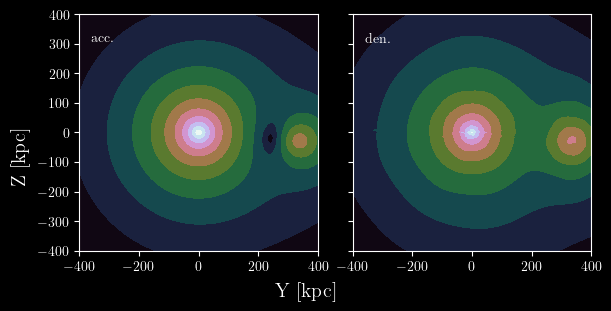

In [9]:
grid = np.linspace(-400, 400, 301)
xyz = np.column_stack(
    [10*np.ones(len(grid)**2),
     np.repeat(grid, len(grid)),
     np.tile(grid, len(grid)),
    ]
)

den_fit = potTotal.density(xyz).reshape(len(grid), len(grid)).T
acc_fit = np.linalg.norm(potTotal.force(xyz), axis=1).reshape(len(grid), len(grid)).T

fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True, constrained_layout=True)

# Plotting loops/logic to keep code DRY (Don't Repeat Yourself)
times = ['Sim', 'Fit']
densities = [acc_fit, den_fit]
labels = ["acc.", "den."]

for i, (t_val, den, lbl) in enumerate(zip(times, densities, labels)):
    # Contour plot
    im = ax[i].contourf(grid, grid, np.log10(den), levels=10, cmap='cubehelix')
    
    # 3. Annotations on top left
    ax[i].text(0.05, 0.92, lbl, transform=ax[i].transAxes, color='white', 
               fontsize=10, fontweight='bold', va='top')

# 4. Common Labels
fig.supxlabel('Y [kpc]')
fig.supylabel('Z [kpc]')

# Limits
ax[0].set_xlim(min(grid), max(grid))
ax[0].set_ylim(min(grid), max(grid))

plt.show()

## Load the entire time-evolv potential

In [10]:
from pathlib import Path
lmax = 8

h5_MW_sph = f'data/MW.none_{lmax}.coef_mult.h5'
h5_MW_azi = f'data/MW.none_{lmax}.coef_cylsp.h5'
h5_LMC_sph = f'data/LMC.none_{lmax}.coef_mult.h5'


LMC_pos_in_MWframe = sim_params['lmc_center'] - sim_params['mw_center']
LMC_vel_in_MWframe = sim_params['lmc_vel'] - sim_params['mw_vel']
time_in_Agama = sim_params['time'] # * Gyr_to_AgamaTime
LMC_traj = np.column_stack([time_in_Agama, LMC_pos_in_MWframe, LMC_vel_in_MWframe])

trajMWx = agama.Spline(time_in_Agama, sim_params['mw_center'][:,0], der=sim_params['mw_vel'][:, 0])
trajMWy = agama.Spline(time_in_Agama, sim_params['mw_center'][:,1], der=sim_params['mw_vel'][:, 1])
trajMWz = agama.Spline(time_in_Agama, sim_params['mw_center'][:,2], der=sim_params['mw_vel'][:, 2])

# MW centre acceleration is minus the second derivative of its trajectory in the inertial frame
accMW   = np.column_stack([time_in_Agama, -trajMWx(time_in_Agama, 2), -trajMWy(time_in_Agama, 2), -trajMWz(time_in_Agama, 2)])
potacc  = agama.Potential(type='UniformAcceleration', file=accMW) # this is the MW-non interial correction acceleration

In [11]:
times = time_in_Agama            # your times array
group_names = None              # or pass explicit list matching `times`
potMW_halo_evolv = load_agama_evolving_potential_from_h5(agama, h5_MW_sph, time_in_Agama, group_names=group_names)
potMW_disk_evolv = load_agama_evolving_potential_from_h5(agama, h5_MW_azi, time_in_Agama)
potLMC_halo_evolv = load_agama_evolving_potential_from_h5(agama, h5_LMC_sph, time_in_Agama, center=LMC_traj)
potTotal_evolv = agama.Potential(potMW_halo_evolv, potMW_disk_evolv, potLMC_halo_evolv)
potTotal_evolv_acc_corr = agama.Potential(potMW_halo_evolv, potMW_disk_evolv, potLMC_halo_evolv, potacc) # this is the correct expansion.

In [12]:
potTotal_evolv.force([10, 0, 0], t=0*Gyr_to_AgamaTime), potTotal_evolv.force([10, 0, 0], t=2*Gyr_to_AgamaTime)

(array([-4437.46931968,    12.85397971,   -83.81285728]),
 array([-4520.16842479,  -104.83028823,  -178.33395165]))

## Compare with precomputed orbits:

In [13]:
with h5py.File("data/orbit_Sheng25_halo_108.h5", "r") as f:
    pos_orbits = f["pos"][:]
    vel_orbits = f["vel"][:]
    pot_orbits = f["pot"][:]
    time_orbits = f["time"][:] * Gyr_to_AgamaTime
MW_center_posvel = np.column_stack([sim_params['mw_center'], sim_params['mw_vel']])
simulated_orbits = np.concatenate([pos_orbits.transpose(1, 0, 2), vel_orbits.transpose(1, 0, 2)], axis=-1) - MW_center_posvel[:100, :]

In [14]:
ics = simulated_orbits[:, 0]
results = agama.orbit(potential=potTotal_evolv, ic=ics, timestart=0, time=time_orbits[-1], trajsize=100)
time_integrator = results[0, 0]
integrated_orbits = np.stack(results[:, 1])

results_acc_corr = agama.orbit(potential=potTotal_evolv_acc_corr, ic=ics, timestart=0, time=time_orbits[-1], trajsize=100)
time_integrator = results_acc_corr[0, 0]
integrated_orbits_acc_corr = np.stack(results_acc_corr[:, 1])

50 orbits complete (57.87 orbits/s)
50 orbits complete (48.54 orbits/s)


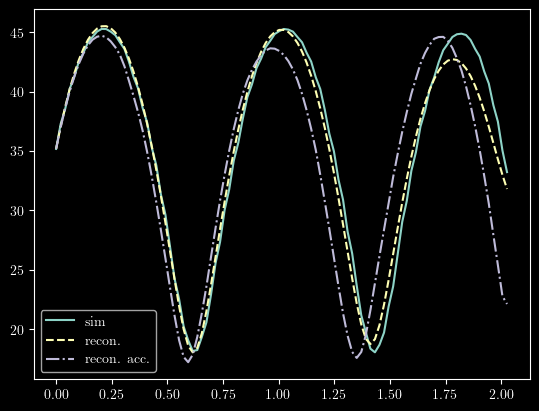

In [15]:
id = 12
plt.plot(time_orbits, np.linalg.norm(simulated_orbits[id, :, :3], axis=1), label='sim')
plt.plot(time_integrator, np.linalg.norm(integrated_orbits[id, :, :3], axis=1), '--',label='recon.')
plt.plot(time_integrator, np.linalg.norm(integrated_orbits_acc_corr[id, :, :3], axis=1), '-.',label='recon. acc.')
plt.legend()

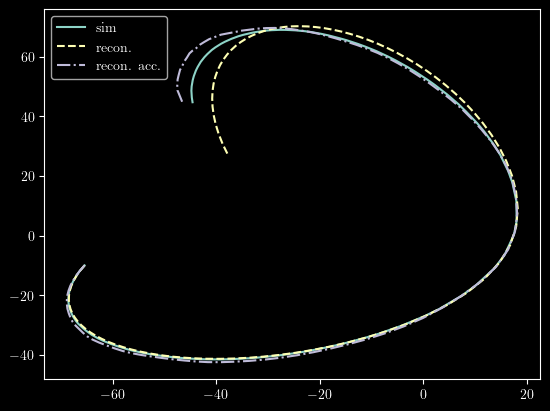

In [16]:
id = 49
x_ax, y_ax = 0, 2
plt.plot(simulated_orbits[id, :, x_ax], simulated_orbits[id, :, y_ax], label='sim')
plt.plot(integrated_orbits[id, :, x_ax], integrated_orbits[id, :, y_ax], '--',label='recon.')
plt.plot(integrated_orbits_acc_corr[id, :, x_ax], integrated_orbits_acc_corr[id, :, y_ax], '-.',label='recon. acc.')
plt.legend()

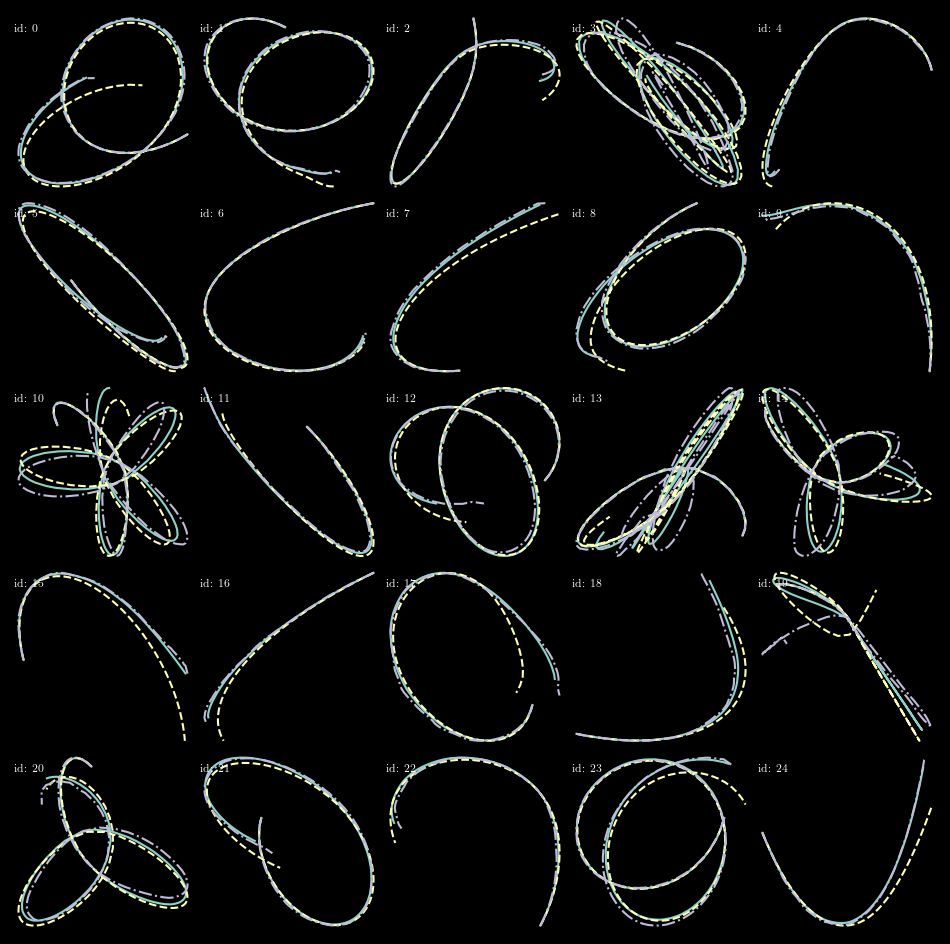

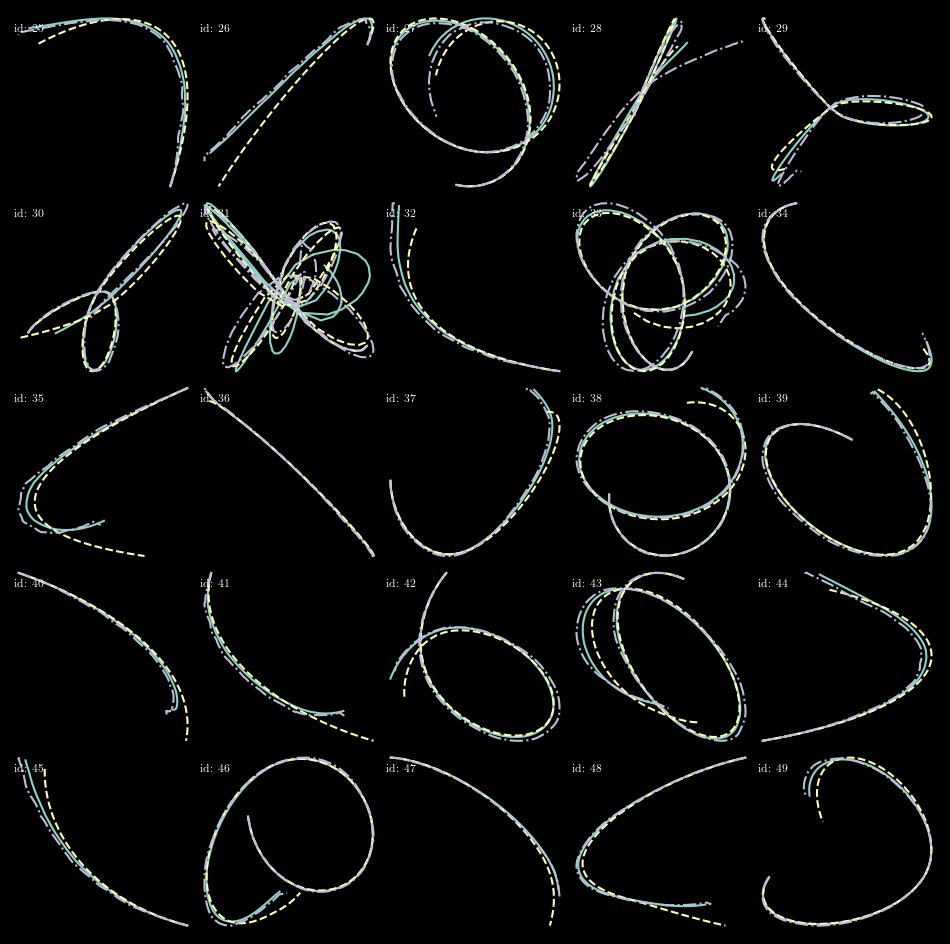

In [17]:
# assumes arrays exist with shape (N_orbits, Nsteps, ndims)
# example: simulated_orbits.shape == (50, T, 3)
x_ax, y_ax = 0, 2  # use the axes you showed

def plot_5x5_grid(start_id, filename):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.ravel()
    N_orbits = simulated_orbits.shape[0]
    for i, ax in enumerate(axes):
        idx = start_id + i
        if idx >= N_orbits:
            ax.axis("off")
            continue
        ax.plot(simulated_orbits[idx, :, x_ax], simulated_orbits[idx, :, y_ax])
        ax.plot(integrated_orbits[idx, :, x_ax], integrated_orbits[idx, :, y_ax], "--")
        ax.plot(integrated_orbits_acc_corr[idx, :, x_ax], integrated_orbits_acc_corr[idx, :, y_ax], "-.")
        ax.axis("off")
        ax.text(0.02, 0.92, f"id: {idx}", transform=ax.transAxes,
                ha="left", va="top", fontsize=8)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    fig.savefig(filename, dpi=200, bbox_inches="tight")
    # plt.close(fig)

# make and save the two grids
plot_5x5_grid(0, "orbits_0-24.png")
plot_5x5_grid(25, "orbits_25-49.png")